## Antenna Matrix Notebook
Katherine Elder

When we made movies of the raw cross-polarized data for the entire IDR2.1 run, we noticed objects that didn't change with time. This would suggest that the data responsible for those objects was not coming from the sky, but from the other antennas. To investigate this further, we decided to look at the delay transforms. As we looked at the various plots, patterns started appearing. For instance, for many antenna pairs, the highest peak in the graph would appear at a delay time roughly corresponding to the baseline length between the antennas. 

### Part 1: Matrix Plots

To get a better look at this and possibly pick up on more patterns, we decided to plot matricies of the antenna pairs. The color of the squares relate to either the amplitude of the maximum peak of the delay transform for the given antenna pair, or the corresponding delay time of the peak. 

To do this, we read in a file holding the entire run of data (created by read_all_uvfits.py) and then run through every unique antenna pair. Without plotting, we find the maximum amplitude (y-value) and it's corresponding delay (x-value). These numbers are placed into arrays and the loop moves onto the next antenna pair. We use plt.matshow to display the arrays side by side as matrices so that we will be able to see if any patterns appear. 

Here's what we want to do: create the array of amplitudes and make a separate array to hold the delay times, since plt.matshow doesn't like arrays of lists. 

Initialize the amp array.

Step into loop for the antenna pair. Only 52 antennas online, but with dead antenna removed only 46 antennas used.

Run through the file and take the fourier transforms. 

Find max of vis_avg_delay and put into amp array. 

Find corresponding delay value and put into delay array. 

Restart loop for new antenna pair. 

Convert data arrays to find the coordinates necessary for building the matrix.

### Step 1:

Import the necessary packages and define universial constants, then read the data files into uv objects. 

These files were created by read_all_uvfits.py using the data from the IDR2.1 LSTBIN. 

In [1]:
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib

#Create uv elements
uvx = UVData()
uvy = UVData()
uvpx = UVData()
uvpy = UVData()

#Create constants
#The speed of light, with power adjusted for desired units
c = 0.299792
#The speed of light in a cable correction factor
f = 0.8

#Create an array of antennas we want to flag
flagged_antennas = [0,2,26,50,98,136]

#Reference lines for plotting in the graphs
diagonals = np.linspace(0,130)
zero_line = np.linspace(0,0)
cable = np.linspace(150,150)

In [2]:
#Read in each of the data files

#Read in the xy data file
uvx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_6.uvOCRSL.uvfits')
#Read in the yx data file
uvy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_7.uvOCRSL.uvfits')
#Read in the xx data file
uvpx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_time_split_data/combined_files/zen.grp1.of1.xx.LST.run_1.uvOCRSL.uvfits')
#Read in the yy data file
uvpy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_yy_time_split_data/combined_files/zen.grp1.of1.yy.LST.run_1.uvOCRSL.uvfits')

Before working with the data, we will define functions to call later in the code. This helps us streamline the code and cut down on unnecessaryly repeating code. 

<b>find_blin_length</b> : The purpose of this function is to read in the selected antenna and calculate the length of each baseline

In [3]:
def find_blin_length(index):
    '''
    The purpose of this function is to read in the selected antenna and calculate the 
    length of each baseline
    
    Parameters
    ----------
    index : int
        The index points to which antenna has been selected by the user
        
    Returns
    -------
    blin_length : ndarray
        This array holds the corresponding distance between each antenna pair
    
    '''
    
    #Create an array which holds the physical distance between each antenna in meters 
    #Initialize it to the desired length and fill with zeros. 
    blin_length = np.zeros((52,1))
    
    #Step through each antenna pair with the entered antenna
    for aa,ant in enumerate(ants):
        #Find the horizontal distance between the two antennas
        x = antpos[index,0] - antpos[aa,0]
        #Find the vertical distance between the two antennas
        y = antpos[index,1] - antpos[aa,1]
        #Find the hypotenus of the triangle, which is the total distance
        diag = np.sqrt(x**2 + y**2)
        #Place this value into the array
        blin_length[aa] = diag
    
    #Return the array of baselines
    return(blin_length)

<b>make_max_arrays</b> : The purpose of this function is to read in all antenna pairs and produce an array of the maximum amplitudes of the delay transform and an array of the corresponding delay times. 

In [4]:
def make_max_arrays(uv,keep_flags=False):
    '''
    The purpose of this function is to read in all antenna pairs
    and produce an array of the maximum amplitudes of the delay transform
    and an array of the corresponding delay times. 

    Parameters 
    ----------
    uv : uv data object
        Name of the uv object being used
    keep_flags : bool, optional
        If this is set to True, a zero will be inserted into the amplitude 
        array when a flagged antenna is encountered. This acts as a placeholder
        so that when the antenna array positions are plotted, all of the antenna
        are present, including the flagged antenna. 
        If the default value is passed, then the function will skip flagged antenna
        and no entry will be placed in the array element.
    
    Returns
    -------
    max_amp, delays : ndarrays
        The first array holds the maximum amplitudes. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
        The second array holds the corresponding delay times. If keep_flags is 
        True, the array will have empty elements to correct the shape and 
        size of the array. 
    '''
    
    #Create the arrays to be returned
    max_amp=[]
    delays=[]
    
    #Loop through each antenna pair
    for i,ant1 in enumerate(uv.ant_1_array):
        #Get the second antenna number using the index number
        ant2 = uv.ant_2_array[i]
        
        #Flag out dead antennas
        #If keep_flags is set to True, a zero entry will be added to the arrays
        #If keep_flags is set to False, the function continues
        if np.any(ant1==flagged_antennas) and keep_flags:
            max_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant1==flagged_antennas):
            continue

        if np.any(ant2==flagged_antennas) and keep_flags:
            max_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif np.any(ant2==flagged_antennas):
            continue
            
        # Check if the antenna numbers are equal
        #If they are, the function will continue
        #If keep_flags is also set to True, a zero entry will be added to the arrays
        #'''
        if ant1==ant2 and keep_flags:
            max_amp.append([ant1,ant2,0])
            delays.append([ant1,ant2,0])
            continue
        elif ant1==ant2:
            continue
        #'''
        
        # Create an array to hold the data for the given antenna pair
        spectrum=uv.data_array[i,0,:,0]
        # Take a Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uv.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs,freq_width))*1e9
        # Find the maximum amplitude and put into a variable
        #This is the absolute maximum of the graph, no matter how many peaks are present
        max_peak = np.max(np.abs(vis_avg_delay))
        #If the maximum peak is zero, meaning there is no peak, the corresponding
        #delay is set to zero. This helps to avoid errors and correct the color scale
        if max_peak==0:
            corr_delay = 0
        #If there is an actual peak present, the corresponding delay time is found
        else: 
            #Find the corresponding delay
            corr_delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==max_peak)]
        # Append the maximum amplitude array with a list of the antenna pair and the peak
        max_amp.append([ant1,ant2,max_peak])
        #Append the delay array with a list of the antenna pair and the delay time
        delays.append([ant1,ant2,corr_delay])

    #Convert to numpy arrays
    max_amp = np.array(max_amp)
    delays = np.array(delays)
    
    #Return the created arrays
    return max_amp, delays;

<b>make_matrix_array</b> : The purpose of this function is to correctly fill the arrays that will be used to plot the matrices. 

In [5]:
def make_matrix_array(amp_array,delay_array,antnum=None,index=False):
    '''
    The purpose of this function is to correctly fill the arrays that will be 
    used to plot the matrices. 
    
    Parameters
    ----------
    amp_array : ndarray
        The array holding the amplitudes
    delay_array : ndarray
        The array holding the delay times
    antnum : int, optional
        The antenna number of a specific antenna to check for. Default is none. 
    index : bool, optional
        If this is set to True, the index number for the entered antenna number
        will be returned as well. 
        
    Returns
    -------
    amp_matrix,delay_matrix : ndarrays
        The first array holds the amplitudes correctly shaped to produce the matrix. 
        The second array hold the delays correctly shaped to produce the matrix. 
    OR
    amp_matrix,delay_matrix,indexnum,dindexnum : ndarrays, ints
        The first array holds the amplitudes correctly shaped to produce the matrix. 
        The second array hold the delays correctly shaped to produce the matrix. 
        indexnum is the integer index number of the amplitude matrix for the entered 
        antenna. This is only returned if index is set to True.
        dindexnum is the integer index number of the delay matrix for the entered 
        antenna. This is only returned if index is set to True.
    
    '''
    
    #Get a list of all of the antennas used and sort them
    antennas = list(set(amp_array[:,0]))
    antennas.sort()
    
    #Find the number of antennas
    nants_peak = len(antennas)
    
    #Create arrays to hold the formatted matrices
    amp_matrix = np.zeros((nants_peak,nants_peak))
    delay_matrix = np.zeros((nants_peak,nants_peak))
    
    #Fill the amplitude matrix array by stepping through the amplitude array
    for ant1,ant2,peak in amp_array:
        #Get the coordinates for the current antenna pair
        i,j = np.argwhere(antennas==ant1),np.argwhere(antennas==ant2)
        #Check if index was set to True
        if index:
            #If one of the current antennas is the antenna entered by the user,
            #then the amplitude value is placed into the correct element
            #The index of the selected antenna is also placed in the specified variable
            if ant1==antnum:
                amp_matrix[i,j] = peak
                indexnum = np.argwhere(antennas==ant1)
            elif ant2==antnum:
                amp_matrix[j,i] = peak
                indexnum = np.argwhere(antennas==ant2)
            #If neither of the antennas match the entered antenna, a zero is placed
            #into the corresponding array element
            else:
                amp_matrix[i,j] = 0
        #If index was not set to true, we check the coordinates and format so that 
        #the larger coordinate is entered second. This makes the matrix look nicer
        elif j<i:
            amp_matrix[j,i] = peak
        else:
            amp_matrix[i,j] = peak
    
    #Now we fill the delay matrix array
    for ant1,ant2,delay in delay_array:
        #Get the coordinate
        i,j = np.argwhere(antennas==ant1),np.argwhere(antennas==ant2)
        #Check if index was set to True
        if index:
            #If one of the current antennas is the antenna entered by the user,
            #then the delay time is placed into the correct element
            #The index of the selected antenna is also placed in the specified variable
            if ant1==antnum:
                delay_matrix[i,j] = delay
                dindexnum = np.argwhere(antennas==ant1)
            elif ant2==antnum:
                delay_matrix[j,i] = delay
                dindexnum = np.argwhere(antennas==ant2)
            #If neither of the antennas match the entered antenna, a zero is placed
            #into the corresponding array element
            else:
                delay_matrix[i,j] = 0
        #If index was not set to true, we check the coordinates and format so that 
        #the larger coordinate is entered second. This makes the matrix look nicer
        elif j<i:
            delay_matrix[j,i] = delay
        else:
            delay_matrix[i,j] = delay
    
    #If index was set to True, return the two arrays and the two index values
    if index:
        return amp_matrix, delay_matrix, indexnum, dindexnum;
    #If index was set to False, only return the two arrays
    else:
        return amp_matrix, delay_matrix;

<b>plot_matrix_array</b> : The purpose of this function is to plot the matrix arrays for both amplitude and delay

In [6]:
def plot_matrix_array(amp_array,amp_matrix,delay_matrix,vmin,vmax,title):
    '''
    The purpose of this function is to plot the matrix arrays for both 
    amplitude and delay
    
    Parameters
    ----------
    amp_array : ndarray
        The amplitude array that is used to get the antenna numbers to be used 
        for tick marks on the graphs
    amp_matrix : ndarray
        The array of amplitudes which will be plotted as a matrix
    delay_matrix : ndarray
        The array of delays which will be plotted as a matrix
    vmin : int
        The minimum value for the delay color scale
    vmin : int
        The maximum value for the delay color scale
    title : str
        The name of the plot    
    
    '''
    
    #Get a list of the antennas to use for tick marks
    antennas = list(set(amp_array[:,0]))
    antennas.sort()

    #Open a figure
    fig = plt.figure(figsize=(11,5))

    #Plot the amplitudes
    #vmin and vmax have been set manually to a range that is usually readable
    ax = fig.add_subplot(121)
    cax = ax.matshow(amp_matrix,norm=SymLogNorm(vmin=200,vmax=10000,linthresh=.1))
    fig.colorbar(cax,label='Amplitude',fraction=0.046, pad=0.04)
    plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
    plt.yticks(np.arange(45), antennas, fontsize=8)
    #Print the title with the entered name
    plt.title(title,pad=20)
    #plt.grid()

    #Plot the delays
    #vmin and vmax are entered by the user and can be changed when called
    ax2 = fig.add_subplot(122)
    cax2 = ax2.matshow(np.abs(delay_matrix),norm=SymLogNorm(vmin=vmin,vmax=vmax,linthresh=.1))
    fig.colorbar(cax2,label='Delay (ns)',fraction=0.046, pad=0.04)
    plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
    plt.yticks(np.arange(45), antennas, fontsize=8)
    plt.title('Delay (ns)',pad=20)
    #plt.grid()

    plt.tight_layout()
    plt.show()

<b>plot_position_array</b> : The purpose of this function is to plot the antenna array in their physical locations, with one plot using the amplitude as the color scale and the other plot using the delay times as the color scale. 

In [7]:
def plot_position_array(amp_array,delay_array,index,dindex,vmin,vmax,title1,title2):
    '''
    The purpose of this function is to plot the antenna array in their physical
    locations, with one plot using the amplitude as the color scale and the other
    plot using the delay times as the color scale. 
    
    Parameters
    ----------
    amp_array : ndarray
        The amplitude array that is used as color scale for the first plot
    delay_array : ndarray
        The delay array that is used as color scale for the first plot
    index : int
        The index number for the amplitude array
    dindex : int
        The index number for the delay array
    vmin : int
        The minimum value for the delay color scale
    vmin : int
        The maximum value for the delay color scale
    title1 : str
        The name of the first plot
    title2 : str
        The name of the second plot
    
    '''
    
    #Open the figure
    plt.figure(figsize=(10,5))
    
    #Create a subplot
    #The first array of antennas plotted has color representing amplitude
    plt.subplot(121)

    #This line of code isn't necessary, but it helps to better format the plot
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',s=3000,color='w')

    #Now we step through each antenna and plot it with the amplitude acting as color
    for aa in range(52):
        #Get the amplitude value for the current antenna pair
        color = amp_array[index,aa]
        #Convert into integer
        color = int(color)
        #Plot the antennas with the corresponding colors
        #vmin and vmax are set manually to a range that is usually readable
        im=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the selected antenna in black
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    #Print the labels and color bar
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title(title1)
    plt.axis('equal')
    plt.colorbar(im, label='Amplitude')

    #Plot the array of antennas with color representing delay time
    plt.subplot(122)

    #Again, this line isn't strictly necessary, but it helps to better format the graph
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)

    #Now we step through each antenna and plot it with the delay acting as color
    for aa in range(52):
        #Get the delay value for the current antenna pair
        dcolor = delay_array[dindex,aa]
        #Convert into integer
        dcolor = int(dcolor)
        #To help with readability, we take the absolute value of the delay time
        dcolor = np.abs(dcolor)
        #Plot the antennas with the corresponding colors
        #vmin and vmax are set by the user and can be changed when calling the function
        dim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=dcolor,norm=SymLogNorm(vmin=vmin,vmax=vmax,linthresh=.1))
    #Print the antenna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in black
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    #Print the labels and colorbar
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title(title2)
    plt.axis('equal')
    plt.colorbar(dim, label='Amplitude')

    plt.tight_layout()
    plt.show()

<b>plot_delay_position</b> : The purpose of this function is to plot the antenna array based on the distance given by the delay time

In [8]:
def plot_delay_position(a_amp,a_delay_dis,c_amp,c_delay_dis,aindex,cindex,title1,title2):
    '''
    The purpose of this function is to plot the antenna array based on the distance
    given by the delay time
    
    Parameters
    ----------
    a_amp : ndarray
        The array of amplitudes
    a_delay_dis : ndarray
        The array of delays in meters
    c_amp : ndarray
        The array of amplitudes which are multiplied by the cable speed factor
    c_delay_dis : ndarray
        The array of delays in meters which correspond to the cable speed correction
    aindex : int
        The index for the amplitude arrays
    cindex : int
        The index within the cable speed corrected arrays
    title1 : str
        The name of the first plot
    title2 : str
        The name of the second plot
    
    '''
    
    #Call the function to find the distance between antennas
    blin_length = find_blin_length(aindex)
    
    #Open the figure
    plt.figure(figsize=(10,5))

    #Plot the array of antennas with color representing the baseline dependent amplitude
    plt.subplot(121)
    for aa,ant in enumerate(ants):
        #Get the amplitude value for the current antenna pair
        color = a_amp[aindex,aa]
        #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
        if ant==focus_ant:
            plt.scatter(0,0,marker='.',color='black',s=2000)
        #Skip flagged antennas
        elif np.any(ant==flagged_antennas): continue
        #Now we plot the remaining antennas with the color representing the amplitude
        #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
        #The y coordinate corresponds to the delay distance found by the antennas
        #vmin and vmax are set manually to a range that is usually readable
        else: im=plt.scatter(blin_length[aa,0],a_delay_dis[aindex,aa],marker='.',s=2000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        #If the current antenna is the focus antenna, manually print number at 0,0
        if ant==focus_ant: 
            plt.text(0,0,ants[aa],color='w',va='center',ha='center')
        #Skip flagged antennas
        elif np.any(ant==flagged_antennas): continue
        #Print the remaining antenna numbers at the correct coordinates
        else: plt.text(blin_length[aa,0],a_delay_dis[aindex,aa],ants[aa],color='w',va='center',ha='center')
    #Plot lines on the diagonals and at zero
    plt.plot(diagonals,-diagonals)
    plt.plot(diagonals,diagonals)
    plt.plot(diagonals,zero_line)
    #Print labels and color bar
    plt.xlabel('Physical Distance (m)')
    plt.ylabel('Delay distance (m)')
    plt.title(title1)
    plt.colorbar(im, label='Amplitude')

    plt.subplot(122)
    #Plot the array of antennas with color representing the baseline independent amplitude
    for aa,ant in enumerate(ants):
        #Get the amplitude value for the current antenna pair
        color = c_amp[cindex,aa]
        #If the current antenna is the entered antenna we are focusing on, print in black and center at 0,0
        if ant==focus_ant:
            plt.scatter(0,0,marker='.',color='black',s=2000)
        #Skip flagged antennas
        elif np.any(ant==flagged_antennas): continue
        #Now we plot the remaining antennas with the color representing the amplitude
        #The x coordinate corresponds to the physical distance separating the antenna from the focus antenna
        #The y coordinate corresponds to the delay distance found by the antennas
        #vmin and vmax are set manually to a rangle that is usually readable
        else: indim=plt.scatter(blin_length[aa,0],c_delay_dis[cindex,aa],marker='.',s=2000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
   
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        #If the current antenna is the focus antenna, manually print number at 0,0
        if ant==focus_ant: 
            plt.text(0,0,ants[aa],color='w',va='center',ha='center')
        #Skip flagged antennas
        elif np.any(ant==flagged_antennas): continue
        #Print the remaining antenna numbers at the correct coordinates
        else: plt.text(blin_length[aa,0],c_delay_dis[cindex,aa],ants[aa],color='w',va='center',ha='center')
    #Plot lines on the diagonal and at zero
    plt.plot(diagonals,-diagonals)
    plt.plot(diagonals,diagonals)
    plt.plot(diagonals,zero_line)
    #Print labels
    plt.xlabel('Physical Distance (m)')
    plt.ylabel('Delay distance (m)')
    plt.title(title2)
    plt.colorbar(indim, label='Amplitude')

    plt.tight_layout()
    plt.show()

<b>check_antnum</b> : The purpose of this function is to check to see if the entered antenna number matches with a known antenna number

In [9]:
def check_antnum(antnum):
    '''
    The purpose of this function is to check to see if the entered antenna number matches 
    with a known antenna number. If it does, the number is printed and returned to the 
    variable that called the function. If it does not, an error message is printed and the 
    user is prompted to enter a new number. The funtion is then called again to check the 
    new number entered. This repeats until the user enters a valid antenna number. 
    
    Parameters
    ----------
    antnum : int
        The antenna number entered by the user
        
    Returns
    -------
    antnum : int
        The antenna number initially entered by the user
    OR
    new_ant : int
        If the first number entered was invalid, the user is prompted to enter a new
        number. If this number is valid, it is returned as an integer. 
        
    '''
    if np.any(antnum==ants):
        print(antnum)
        return antnum
    else:
        print 'Number entered does not correspond to a known antenna.'
        new_ant = input("Which antenna would you like to look at? Enter here: ")
        new_ant = int(new_ant)
        new_ant = check_antnum(new_ant)
        return int(new_ant)

### Step 2: 

Now that all of our functions are defined, it is time to create the plots for the data. 

We start with the xy or EN polarized data. We first call our functions to create the arrays, then plot. 

In [13]:
#Initialize the array for the amplitudes of the xy data and the corresponding delay
#The only required parameter is the uv object
max_amp_xy,delay_xy=make_max_arrays(uv = uvx)

#Print the shape of the arrays to verify that the function worked properly
print delay_xy.shape
print max_amp_xy.shape

#Initialize the matrix arrays of the xy data
#The arrays created above are passed into the function 
amp_matrix_xy,delay_matrix_xy=make_matrix_array(amp_array = max_amp_xy, delay_array = delay_xy)

#Print the shape of the arrays to verify that the function worked properly
print amp_matrix_xy.shape
print delay_matrix_xy.shape

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Now that the arrays have been created and formatted correctly, it is time to plot the matrices.

<IPython.core.display.Javascript object>


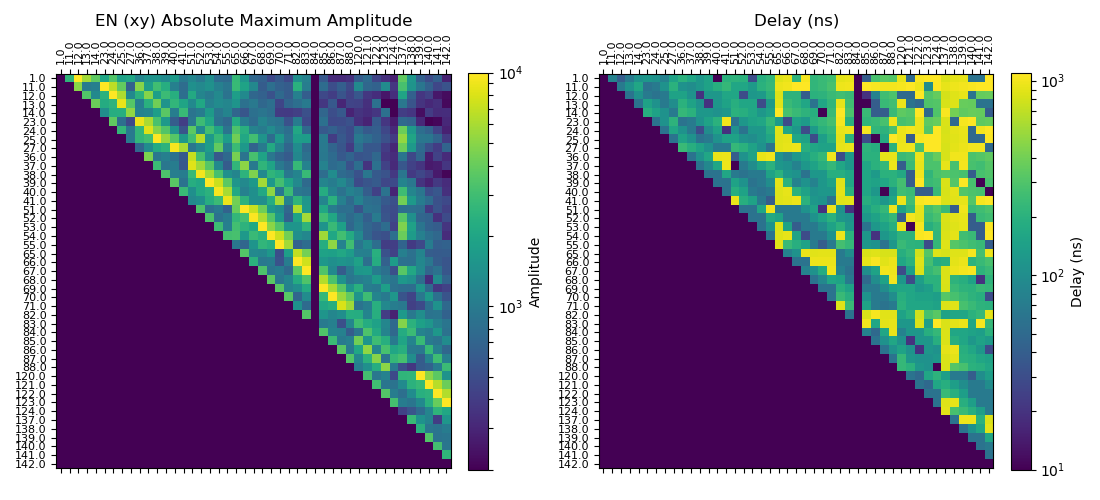

In [11]:
#Call the matrix plotting function

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
plot_matrix_array(amp_array = max_amp_xy, amp_matrix = amp_matrix_xy, delay_matrix = delay_matrix_xy,
                  vmin = 10, vmax = 1100,
                  title='EN (xy) Absolute Maximum Amplitude')

Now we do the same thing for the yx or NE polarized data

In [14]:
#Initialize the arrays for the amplitudes of the yx data and the corresponding delay
#The only parameter passed is the uv object
max_amp_yx,delay_yx=make_max_arrays(uv = uvy)

#Print the shape of the arrays to verify that the function worked properly
print delay_yx.shape
print max_amp_yx.shape

#Initialize the matrix arrays of the yx data
#The arrays created above are passed into the function 
amp_matrix_yx,delay_matrix_yx=make_matrix_array(amp_array = max_amp_yx, delay_array = delay_yx)

#Print the shape of the arrays to verify that the function worked properly
print amp_matrix_yx.shape
print delay_matrix_yx.shape

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Now we can plot the matrices. 

<IPython.core.display.Javascript object>


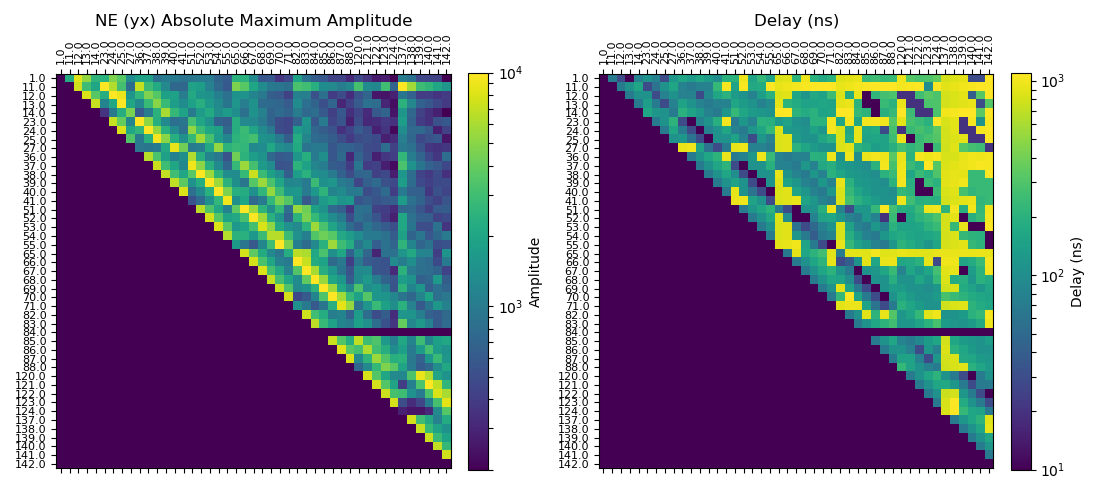

In [15]:
#Call the matrix plotting function

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
plot_matrix_array(amp_array = max_amp_yx, amp_matrix = amp_matrix_yx, delay_matrix = delay_matrix_yx,
                  vmin = 10, vmax = 1100,
                  title = 'NE (yx) Absolute Maximum Amplitude')

To double check that the matrix plots above are making sense, let's take a look at the delay transform for a given set of antennas directly. 

In [38]:
#Get the data for a given set of antennas
vis = uvx.get_data(11,24)
print vis
print vis.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay = np.fft.fftshift(np.fft.fft(np.mean(vis,axis=0)))
print vis_avg_delay
print vis_avg_delay.shape

# 2) Find the frequency width of a channel in GHz
freq_width = np.diff(uvx.freq_array[0,:])[0]
print freq_width

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays = np.fft.fftshift(np.fft.fftfreq(uvx.Nfreqs,freq_width))*1e9
print delays
print delays.shape

print np.max(np.abs(vis_avg_delay))
print delays[np.argmax(np.abs(vis_avg_delay))]

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[39.023193-26.938965j  11.207397-26.967896j  -9.935989-11.9227295j ...
 48.29651 +23.847168j  69.73798  +6.597046j  54.923553-25.647827j ]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
6790.61
-70.0


In [39]:
#Get the data for a given antenna pair
vis2 = uvy.get_data(11,24)
print vis2
print vis2.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay2 = np.fft.fftshift(np.fft.fft(np.mean(vis2,axis=0)))
print vis_avg_delay2
print vis_avg_delay2.shape

# 2) Find the frequency width of a channel in GHz
freq_width2 = np.diff(uvy.freq_array[0,:])[0]
print freq_width2

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays2 = np.fft.fftshift(np.fft.fftfreq(uvy.Nfreqs,freq_width2))*1e9
print delays2
print delays2.shape

print np.max(np.abs(vis_avg_delay2))
print delays2[np.argmax(np.abs(vis_avg_delay2))]

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[40.77292 -50.38965j  19.038452-62.320805j 11.582718-29.97754j  ...
 49.523315-20.20697j  40.238556-52.548218j 22.068115-49.180786j]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
6388.564
-60.00000000000001


In [16]:
#Plot the two delay transforms

#plt.figure(figsize=(9,4))

plt.subplot(121)
plt.plot(delays,np.abs(vis_avg_delay))
plt.xlabel('Delay (ns)')
#plt.xlim(100,200) # zoom-in
#plt.ylim(0,600)
plt.title('XY Delay Transform');

plt.subplot(122)
plt.plot(delays2,np.abs(vis_avg_delay2))
plt.xlabel('Delay (ns)')
#plt.ylim(0,500)
#plt.xlim(-1000,1000) # zoom-in
plt.title('YX Delay Transform');

plt.tight_layout()

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


NameError: name 'delays' is not defined

Lastly, we plot the two amplitude matrices side by side with the same color scale. This allows us to compare the results and pick out any obvious patterns in the two plots. 

<IPython.core.display.Javascript object>


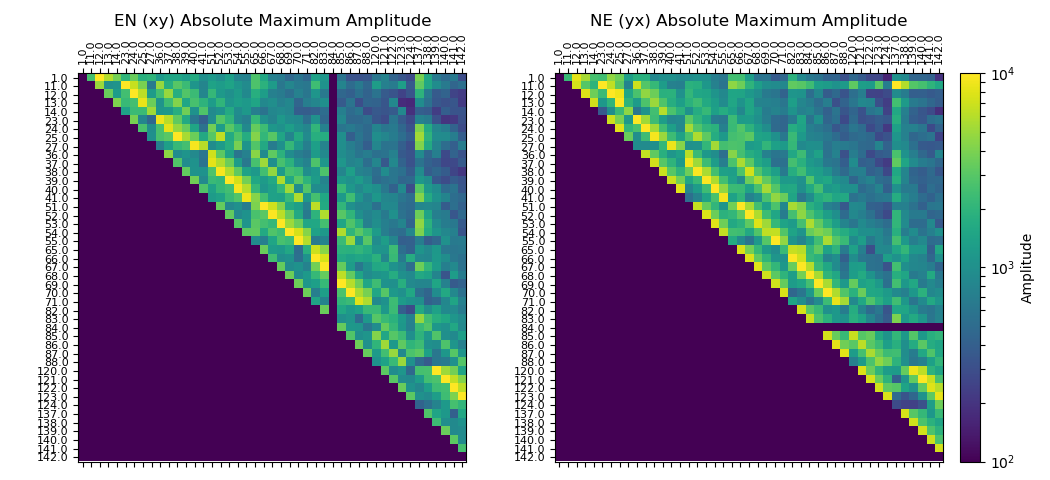

In [43]:
#Plot the amplitudes for both polarizations side by side, with the same color scale
#Make a list of the antennas to use as the tick marks
antennas = list(set(max_amp_xy[:,0]))
antennas.sort()

fig = plt.figure(figsize=(10.5,4.8))

ax_1 = fig.add_subplot(121)
cax_1 = ax_1.matshow(amp_matrix_xy,norm=SymLogNorm(vmin=100,vmax=10000,linthresh=.1))
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('EN (xy) Absolute Maximum Amplitude',pad=20)
#plt.grid()

ax_2 = fig.add_subplot(122)
cax_2 = ax_2.matshow(amp_matrix_yx,norm=SymLogNorm(vmin=100,vmax=10000,linthresh=.1))
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('NE (yx) Absolute Maximum Amplitude',pad=20)
#plt.grid()

plt.colorbar(cax_2, label='Amplitude',fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Part 2: Antenna position plots

We've been able to plot matrices of the maximum amplitude, but now we want to be able to visualize where the antennas actually are in relation to each other (for instance, could then see that the antennas next to each other are most strongly correlated). 

We will do this by first having the user enter an antenna number. This antenna will be the focus antenna which will then be paired with every other antenna to look at the amplitudes and delays, as seen above. Essentially, we will be looking at a single row or column of the matrix plots above. 

### Step 1: 

First, we find the antenna positions and antenna numbers listed in the data. Then we prompt the user to enter an antenna number. This number is fed into a check function and then the arrays are created.

In [18]:
#Read in the position and antenna numbers for all antennas
antpos, ants = uvx.get_ENU_antpos()

In [23]:
#Ask the user to input the desired antenna
focus_ant = input("Which antenna would you like to look at? Enter here: ")
#Take the input and represent as an integer
focus_ant = int(focus_ant)
#Run a check that the number is valid
focus_ant = check_antnum(antnum = focus_ant)

Which antenna would you like to look at? Enter here: 24
24


In [24]:
#Call make_array functions for the xy and yx data

#Create the arrays for the max amplitude and corresponding delay for the xy data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_xy, full_ant_delay_xy = make_max_arrays(uv = uvx, keep_flags = True)

#Create the matrix arrays for the xy data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#index = index number for the amplitude array
#dindex = index number for the delay array
all_ants_amp_xy, all_ants_delay_xy, index, dindex = make_matrix_array(amp_array = full_ant_amp_xy, 
                                                                      delay_array = full_ant_delay_xy, 
                                                                      antnum = focus_ant, index = True)

#Create the arrays for the max amplitude and corresponding delay for the yx data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_yx, full_ant_delay_yx = make_max_arrays(uv = uvy, keep_flags = True)

#Create the matrix arrays for the yx data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#indexy = index number for the amplitude array
#dindexy = index number for the delay array
all_ants_amp_yx, all_ants_delay_yx, indexy, dindexy = make_matrix_array(amp_array = full_ant_amp_yx, 
                                                                        delay_array = full_ant_delay_yx, 
                                                                        antnum = focus_ant, index = True)

Now we can actually plot the antennas with both amplitude and delay fuctioning as the color scale

<IPython.core.display.Javascript object>


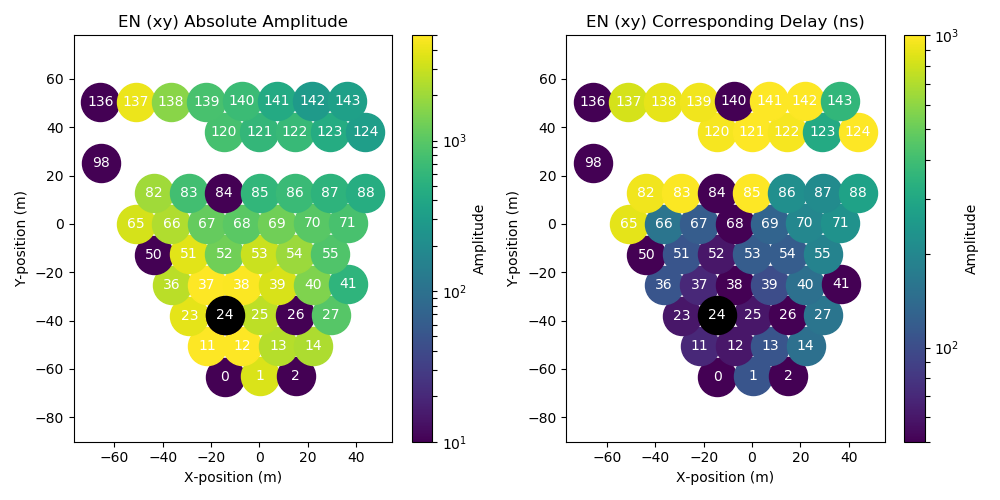

In [25]:
#Call the position plotting function for the xy data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_position_array(amp_array = all_ants_amp_xy, delay_array = all_ants_delay_xy,
                    index = index, dindex = dindex,
                    vmin = 50, vmax = 1000,
                    title1 = 'EN (xy) Absolute Amplitude',
                    title2 = 'EN (xy) Corresponding Delay (ns)')


<IPython.core.display.Javascript object>


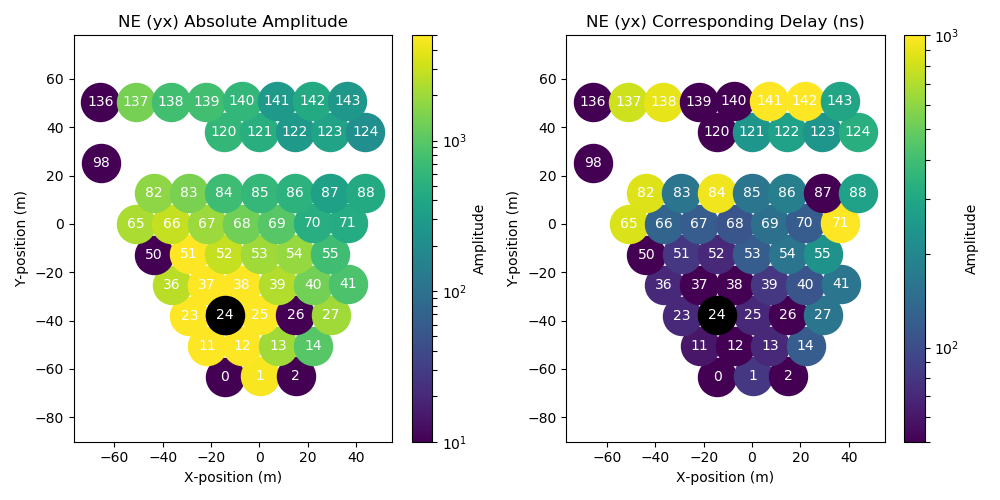

In [26]:
#Call the position plotting function for the yx data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_position_array(amp_array = all_ants_amp_yx, delay_array = all_ants_delay_yx,
                    index = indexy,dindex = dindexy,
                    vmin = 50,vmax = 1000,
                    title1 = 'NE (yx) Absolute Amplitude',
                    title2 = 'NE (yx) Corresponding Delay (ns)')

### Step 2:

Now let's look at how far away the delay times correspond to. This means that instead of plotting the antenna amplitudes at the given antenna location, we need to plot them at the distance given by the delay. 

The delay is given in ns and we need it in m: distance = all_ants_delay[index,aa] $*$ 3e8

OR, taking into account the fact that light moves more slowly in cables:

distance = all_ants_delay[index,aa] $*$ 3e8 $*$ 0.8

We also need to know the physical distance separating the antennas. This can be done by indexing the antenna positions array to get the x and y coordinates of the given antenna pair. The difference between the two x coordinates acts as the horizontal distance between the two antennas, and the difference between the two y coordinates acts as the vertical distance. 

These two numbers act as the sides of a triangle and the hypotenus is the total physical distance between the antennas in meters. This number is then placed in the corresponding array element. 

In [27]:
#Create an array which holds the delay times in meters
delay_distance = all_ants_delay_yx * c
delay_distance_xy = all_ants_delay_xy * c

#Create an array which holds the delay times in meters, with the cable correction factor
dd_cable_yx = all_ants_delay_yx * c * f
dd_cable_xy = all_ants_delay_xy * c * f


<IPython.core.display.Javascript object>


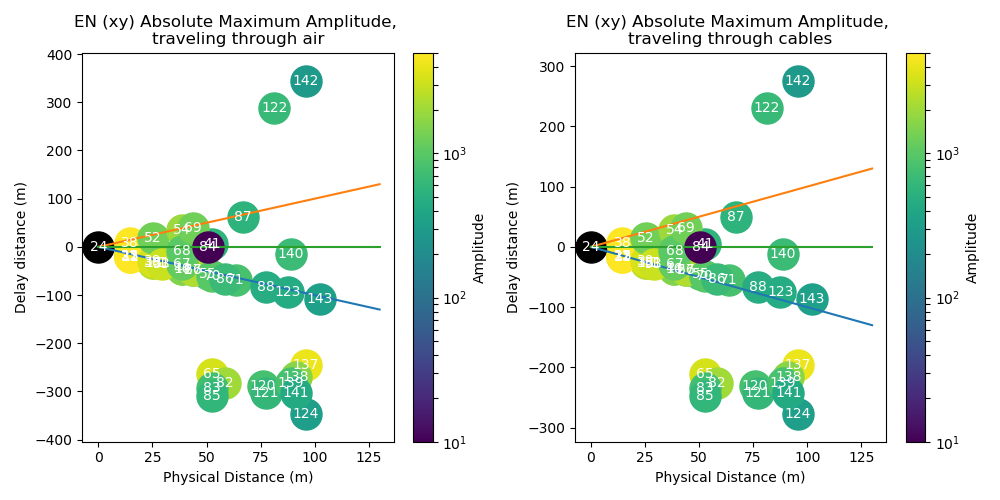

In [31]:
#Call the delay position plotting function for the xy data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_delay_position(a_amp = all_ants_amp_xy, a_delay_dis = delay_distance_xy,
                    c_amp = all_ants_amp_xy, c_delay_dis = dd_cable_xy,
                    aindex = index, cindex = index,
                    title1 = 'EN (xy) Absolute Maximum Amplitude, \ntraveling through air',
                    title2 = 'EN (xy) Absolute Maximum Amplitude, \ntraveling through cables')


<IPython.core.display.Javascript object>


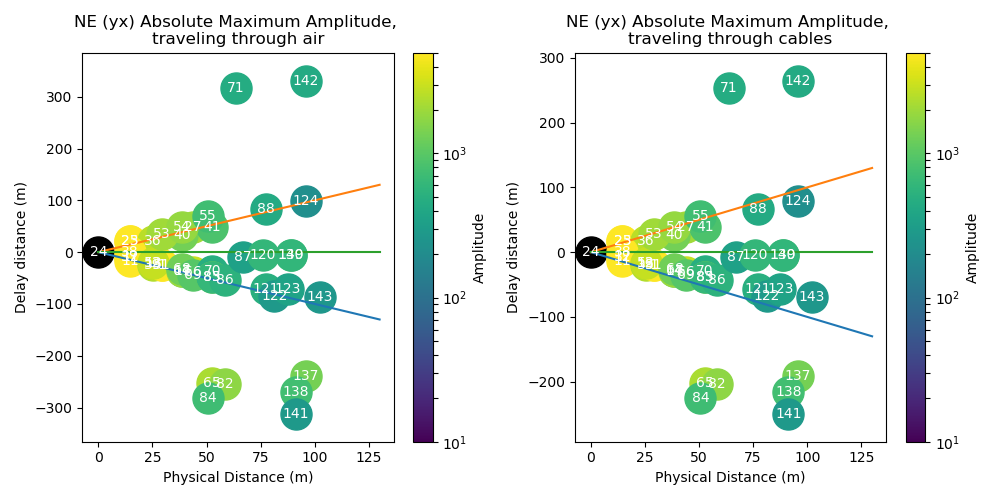

In [32]:
#Call the delay position plotting function for the yx data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified

plot_delay_position(a_amp = all_ants_amp_yx, a_delay_dis = delay_distance,
                    c_amp = all_ants_amp_yx, c_delay_dis = dd_cable_yx,
                    aindex = indexy, cindex = indexy,
                    title1 = 'NE (yx) Absolute Maximum Amplitude, \ntraveling through air',
                    title2 = 'NE (yx) Absolute Maximum Amplitude, \ntraveling through cables')


### Part 3: Parallel Polarizations

Now we want to take a look at the parallel polarized data and create all the same plots as we have above. 

First we initialize the arrays as above, and then create the plots

In [50]:
# Initialize the array for the amplitudes of the xx and yy data and the corresponding delays

#The only required parameter is the uv object
max_amp_xx,delay_xx = make_max_arrays(uv = uvpx)
max_amp_yy, delay_yy = make_max_arrays(uv = uvpy)

#Print the shape of the arrays to verify that the function worked properly
print delay_xx.shape
print max_amp_xx.shape
print delay_yy.shape
print max_amp_yy.shape

#Initialize the matrix arrays of the xy data
#The arrays created above are passed into the function 
amp_matrix_xx, delay_matrix_xx = make_matrix_array(amp_array = max_amp_xx, delay_array = delay_xx)
amp_matrix_yy, delay_matrix_yy = make_matrix_array(amp_array = max_amp_yy, delay_array = delay_yy)

#Print the shape of the arrays to verify that the function worked properly
print amp_matrix_xx.shape
print delay_matrix_xx.shape
print amp_matrix_yy.shape
print delay_matrix_yy.shape

(1035, 3)
(1035, 3)
(1035, 3)
(1035, 3)


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


(45, 45)
(45, 45)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


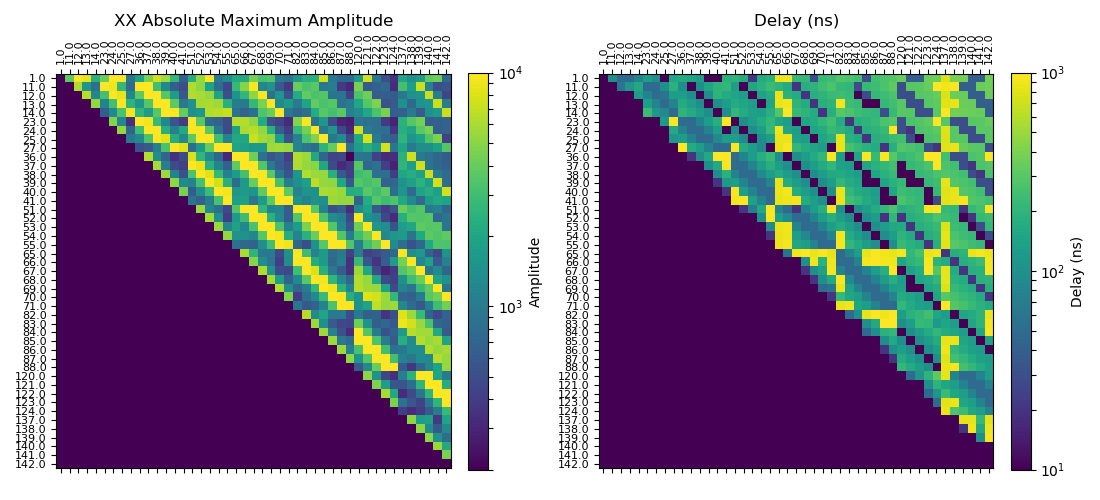

In [34]:
#Call the matrix plotting function for the xx data

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
plot_matrix_array(amp_array = max_amp_xx, amp_matrix = amp_matrix_xx, delay_matrix = delay_matrix_xx,
                  vmin = 10, vmax = 1000,
                  title = 'XX Absolute Maximum Amplitude')

<IPython.core.display.Javascript object>


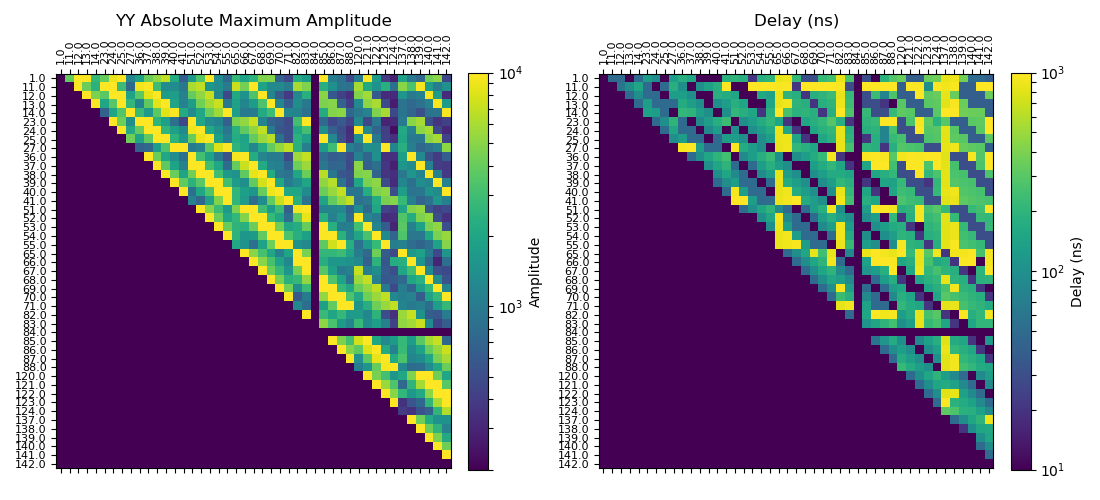

In [39]:
#Call the matrix plotting function for the yy data

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
plot_matrix_array(amp_array = max_amp_yy, amp_matrix = amp_matrix_yy, delay_matrix = delay_matrix_yy,
                  vmin = 10, vmax = 1000,
                  title = 'YY Absolute Maximum Amplitude')

In [51]:
#Call make_array functions for the xx and yy data

#Create the arrays for the max amplitude and corresponding delay for the xx data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_xx, full_ant_delay_xx = make_max_arrays(uv = uvpx, keep_flags = True)

#Create the matrix arrays for the xx data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#index = index number for the amplitude array
#dindex = index number for the delay array
all_ants_amp_xx, all_ants_delay_xx, indexx, dindexx = make_matrix_array(amp_array = full_ant_amp_xx, 
                                                                      delay_array = full_ant_delay_xx, 
                                                                      antnum = focus_ant, index = True)


#Create the arrays for the max amplitude and corresponding delay for the yy data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_yy, full_ant_delay_yy = make_max_arrays(uv = uvpy, keep_flags = True)

#Create the matrix arrays for the yy data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#index = index number for the amplitude array
#dindex = index number for the delay array
all_ants_amp_yy, all_ants_delay_yy, indeyy, dindeyy = make_matrix_array(amp_array = full_ant_amp_yy, 
                                                                      delay_array = full_ant_delay_yy, 
                                                                      antnum = focus_ant, index = True)

<IPython.core.display.Javascript object>


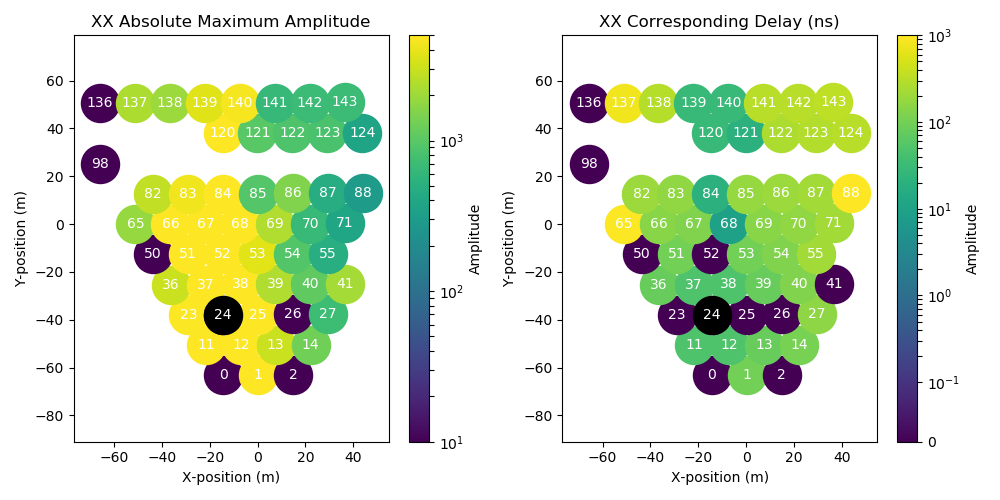

In [36]:
#Call the position plotting function for the xx data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_position_array(amp_array = all_ants_amp_xx, delay_array = all_ants_delay_xx,
                    index = indexx,dindex = dindexx,
                    vmin = 0,vmax = 1000,
                    title1 = 'XX Absolute Maximum Amplitude',
                    title2 = 'XX Corresponding Delay (ns)')

<IPython.core.display.Javascript object>


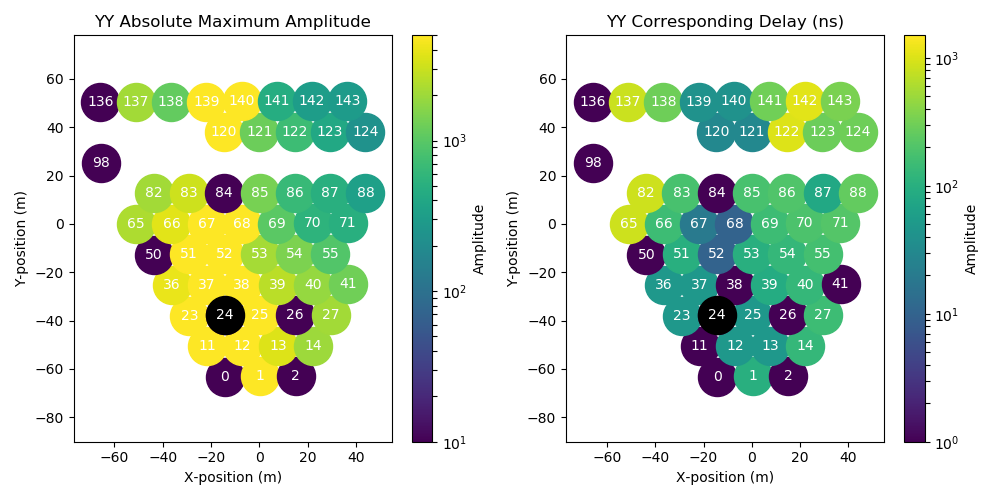

In [44]:
#Call the position plotting function for the yy data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_position_array(amp_array = all_ants_amp_yy, delay_array = all_ants_delay_yy,
                    index = indeyy,dindex = dindeyy,
                    vmin = 1,vmax = 1500,
                    title1 = 'YY Absolute Maximum Amplitude',
                    title2 = 'YY Corresponding Delay (ns)')

In [52]:
#Create an array which holds the delay times in meters for the xx and yy data
delay_distance_xx = all_ants_delay_xx * c
delay_distance_yy = all_ants_delay_yy * c

#Create an array which holds the delay times in meters, with the cable correction factor
dd_cable_xx = all_ants_delay_xx * c * f
dd_cable_yy = all_ants_delay_yy * c * f


<IPython.core.display.Javascript object>


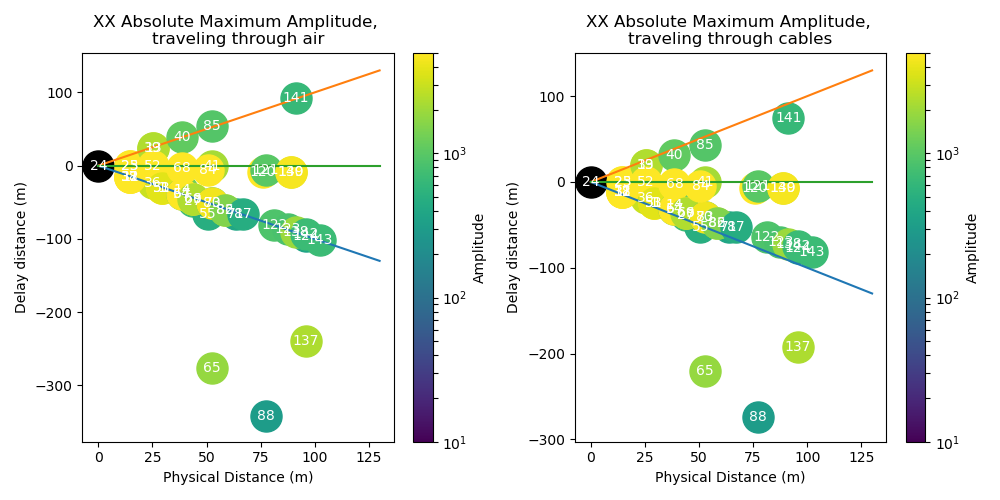

In [54]:
#Call the delay position plotting function for the xx data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_delay_position(a_amp = all_ants_amp_xx, a_delay_dis = delay_distance_xx,
                    c_amp = all_ants_amp_xx, c_delay_dis = dd_cable_xx,
                    aindex = indexx, cindex = indexx,
                    title1 = 'XX Absolute Maximum Amplitude, \ntraveling through air',
                    title2 = 'XX Absolute Maximum Amplitude, \ntraveling through cables')

<IPython.core.display.Javascript object>


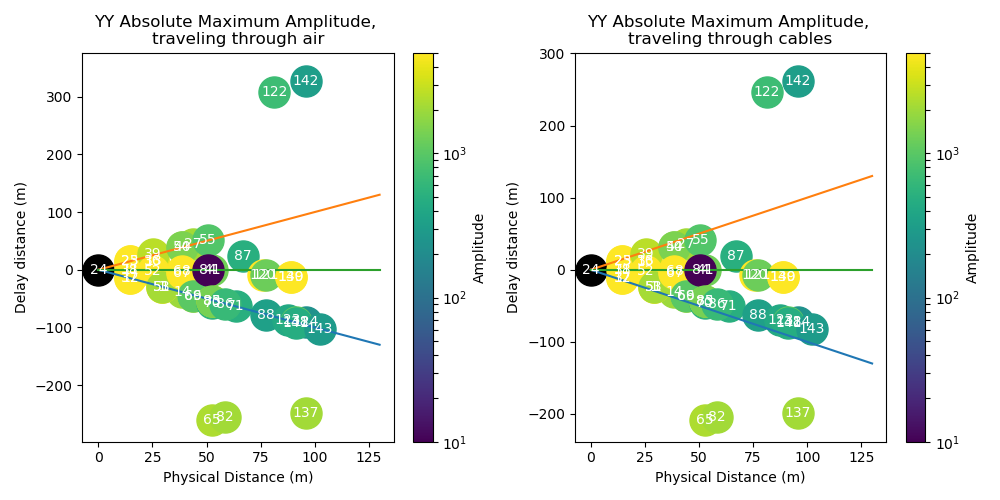

In [56]:
#Call the delay position plotting function for the yy data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
plot_delay_position(a_amp = all_ants_amp_yy, a_delay_dis = delay_distance_yy,
                    c_amp = all_ants_amp_yy, c_delay_dis = dd_cable_yy,
                    aindex = indeyy, cindex = indeyy,
                    title1 = 'YY Absolute Maximum Amplitude, \ntraveling through air',
                    title2 = 'YY Absolute Maximum Amplitude, \ntraveling through cables')

### Part 4: Making movies

As interesting as all of these plots are, it can be tiring going through and rerunning the code for every antenna you want to take a look at. It would be helpful to be able to make a movie of the plots which cycles through each antenna as the "focus antenna". 

The script below saves out the plots as pngs and can be modified to specify which polarization you would like to run. 

After all of the pngs have been saved, the following command can be entered into the command line to create the movie: 

ffmpeg -framerate 2 -pattern_type glob -i '$*$.png' -c:v libx264 -pix_fmt yuv420p out.mp4

In [32]:
'''
for focus_ant in ants:
    #Create the arrays for the maximum values and the matrix for yx
    full_ant_amp_yy, full_ant_delay_yy = make_max_arrays(uvpy, keep_flags=True)
    all_ants_amp_yy, all_ants_delay_yy, indeyy, dindeyy = make_matrix_array(full_ant_amp_yy, full_ant_delay_yy, antnum=focus_ant, index=True)

    #Plot the array of antennas with color representing amplitude for xy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',s=3000,color='w')
    for aa in range(52):
        #Get the amplitude value for the current antenna pair
        color = all_ants_amp_yy[indeyy,aa]
        #Convert into integer
        color = int(color)
        #Plot the antennas with the corresponding colors
        xim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in red
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title('NE antenna correlation')
    plt.axis('equal')
    plt.colorbar(xim)

    #Plot the array of antennas with color representing delay time
    plt.subplot(122)
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
    for aa in range(52):
        #Get the delay value for the current antenna pair
        dcolor = all_ants_delay_yy[dindeyy,aa]
        #Convert into integer
        dcolor = int(dcolor)
        dcolor = np.abs(dcolor)
        #Plot the antennas with the corresponding colors
        dxim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=dcolor,norm=SymLogNorm(vmin=50,vmax=1500,linthresh=.1))
    #Print the antenna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in red
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title('YY Delay correlation')
    plt.axis('equal')
    plt.colorbar(dxim)

    plt.tight_layout()

    imname = '0' + str(focus_ant) + '_yy.png'
    plt.savefig('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/ant_array_imgs/yy_imgs/'+imname)
'''

"\nfor focus_ant in ants:\n    #Create the arrays for the maximum values and the matrix for yx\n    full_ant_amp_yy, full_ant_delay_yy = make_max_arrays(uvpy, keep_flags=True)\n    all_ants_amp_yy, all_ants_delay_yy, indeyy, dindeyy = make_matrix_array(full_ant_amp_yy, full_ant_delay_yy, antnum=focus_ant, index=True)\n\n    #Plot the array of antennas with color representing amplitude for xy\n    plt.figure(figsize=(10,5))\n    plt.subplot(121)\n    plt.scatter(antpos[:,0],antpos[:,1],marker='.',s=3000,color='w')\n    for aa in range(52):\n        #Get the amplitude value for the current antenna pair\n        color = all_ants_amp_yy[indeyy,aa]\n        #Convert into integer\n        color = int(color)\n        #Plot the antennas with the corresponding colors\n        xim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))\n    #Print the antetnna numbers\n    for aa,ant in enumerate(ants):\n        plt.text(antpos[aa,0],antpo